<a href="https://colab.research.google.com/github/khalit7/PyTorchMnistClassification/blob/main/PyTorchMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
import torchvision
import torch
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import hiddenlayer as hl
from IPython.display import Image

import matplotlib.pyplot as plt


In [38]:
pip install hiddenlayer

In [6]:
n_epochs = 3
batch_size_ = 32
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [7]:
train_set = torchvision.datasets.FashionMNIST (root = ".", train = True ,
download = True , transform = transforms.ToTensor ())
test_set = torchvision .datasets. FashionMNIST (root = ".", train = False ,
download = True , transform = transforms.ToTensor ())
training_loader = torch.utils.data.DataLoader (train_set , batch_size = batch_size_,
shuffle = False)
test_loader = torch.utils.data.DataLoader (test_set , batch_size = batch_size_,
shuffle = False)


In [14]:
example = enumerate(training_loader)
batc_idx , (example_data,example_target) = next(example)

In [15]:
example_data.shape

torch.Size([32, 1, 28, 28])

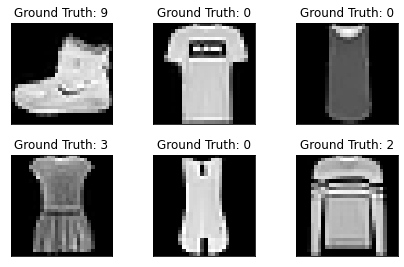

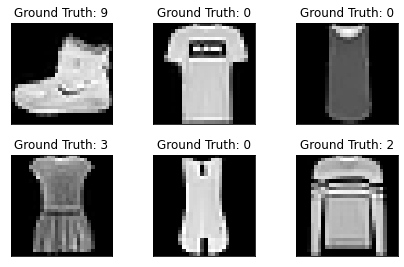

In [21]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_target[i]))
  plt.xticks([])
  plt.yticks([])
fig

lets build the network


In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

initialize parameters

In [24]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

display model's archetecture

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:258: UserWarning: ONNX export failed on feature_dropout because training mode not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:1630: UserWarning: Dropout is a training op and should not be exported in inference mode. For inference, make sure to call eval() on the model and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "


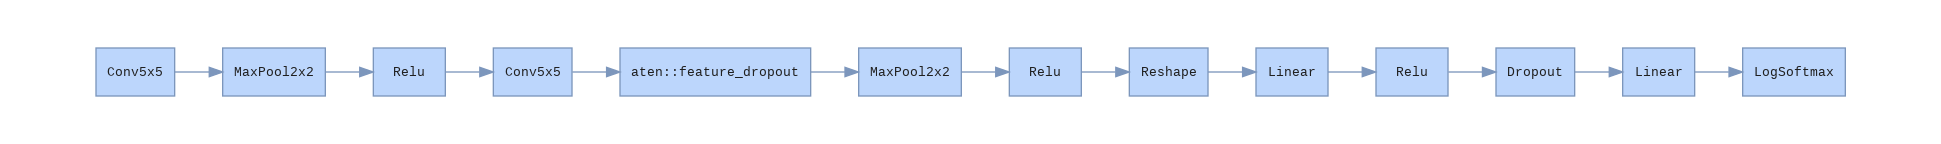

In [49]:
print(network)
transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

graph = hl.build_graph(network, example_data,transforms = transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('CNN_Model', format='png')
Image('CNN_Model.png')